In [11]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time

In [13]:
# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

<Figure size 432x288 with 0 Axes>

# Create zones and add basic information
## Zones Berliner Ortsteile, number of inhabitants 
Uses Berliner Ortsteile (n=98), source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_ortsteile

Population data on bulding block level 2020, source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s06_06ewdichte2020

In [14]:
input_path = '../input/zones/'
output_path = '../output/'
model_path = '../model/'

In [15]:
# Initialising StepModel...
sm = stepmodel.StepModel(debug=False,
                         walk_on_road=False,
                         epsg=4326,
                         coordinates_unit=None)

### read in Berliner Ortsteile shapefile

<AxesSubplot:>

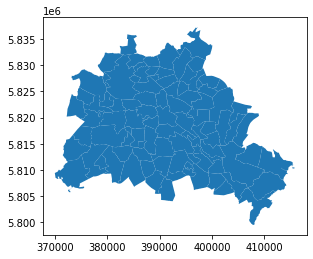

In [16]:
# Adding zones...
zones = gpd.read_file(input_path + "Berliner_Ortsteile.shp")
# remove duplicate zone (Buch)
zones = zones[list(map(lambda x: x not in zones[zones["nam"]=="Buch"][1:].index, zones.index))]
zones = zones.reset_index()
zones["zoneIndex"] = zones.index
sm.zones = zones
zones.plot()

In [17]:
# change crs to Söldner CRS 
#crs_code = 3068
# set to standard CRS for compatability with osmnx 
crs_code = 4326
sm.zones = sm.zones.to_crs(epsg = crs_code)

In [18]:
sm.zones.head(2)

,index,uuid,sch,nam,gdf,bezeich,geometry,zoneIndex
0,0,DEBE04YY5000000B,110000040403,Schmargendorf,3588120.0,AX_KommunalesGebiet,"POLYGON ((13.29468 52.49183, 13.29469 52.49183...",0
1,1,DEBE04YY50000001,110000040405,Westend,13527378.0,AX_KommunalesGebiet,"POLYGON ((13.28118 52.53049, 13.28180 52.53028...",1


### read and clean in building block shapefile

In [19]:
# Add building block shapefile
buildings = gpd.read_file(input_path + "Einwohnerdichte_2020.shp")
# remove buildings without geometry property
print("removing", sum(buildings.geometry == None), 
      "buildings with",
      round(sum(buildings[buildings.geometry == None]["ew2020"])),
      "inhabitants due to lack of geometry, e.g. building with schl5 =",
     buildings[buildings.geometry == None].iloc[0]["schl5"])
buildings = buildings[buildings.geometry != None]
buildings["zone"] = -1

removing 127 buildings with 4863 inhabitants due to lack of geometry, e.g. building with schl5 = None


In [20]:
buildings.head(2)

,schl5,ew2020,flalle,ew_ha_2020,typklar,area_calc,geometry,zone
0,0100980011000100,3.0,4624.0,6.487889,Freie Zeilenbebauung mit landschaftlichem Sied...,4623.945832,"POLYGON ((389326.214 5821756.291, 389344.806 5...",-1
1,0100980011000300,21.0,5604.0,37.473233,Geschosswohnungsbau der 1990er Jahre und jünger,5603.674449,"POLYGON ((389261.965 5821859.562, 389236.247 5...",-1


<AxesSubplot:>

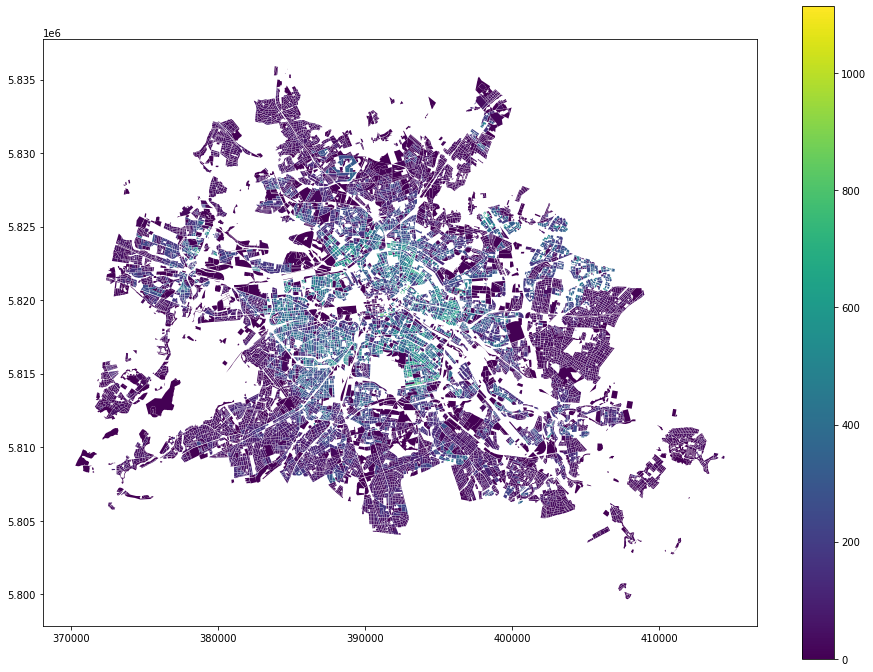

In [21]:
fig, ax = plt.subplots(figsize = (16,12))
buildings.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", legend=True)

### assign a zone to each building

In [28]:
t0=time.time()
# assign zone to each building # very slow algorithm, think whether it can be done withoug nested loop
for index, row in buildings.iterrows():
    centroid = row.geometry.centroid
    zoneIndex = 0
    # test for each zone whether the centroid lies within. 
    # if so assign this building to the zone
    while not centroid.intersects(zones.iloc[zoneIndex].geometry):
        zoneIndex += 1
        if(zoneIndex > max(zones["zoneIndex"])):
            zoneIndex = -1
            break
    
    buildings.at[index, "zone"] = zoneIndex
    helpers.printProgress(i=index, imax=len(buildings), t=time.time(), t0=t0)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 04:08. Minutes remaining: 00:00. 

Text(0.5, 1.0, 'Assignment of buildings to zones')

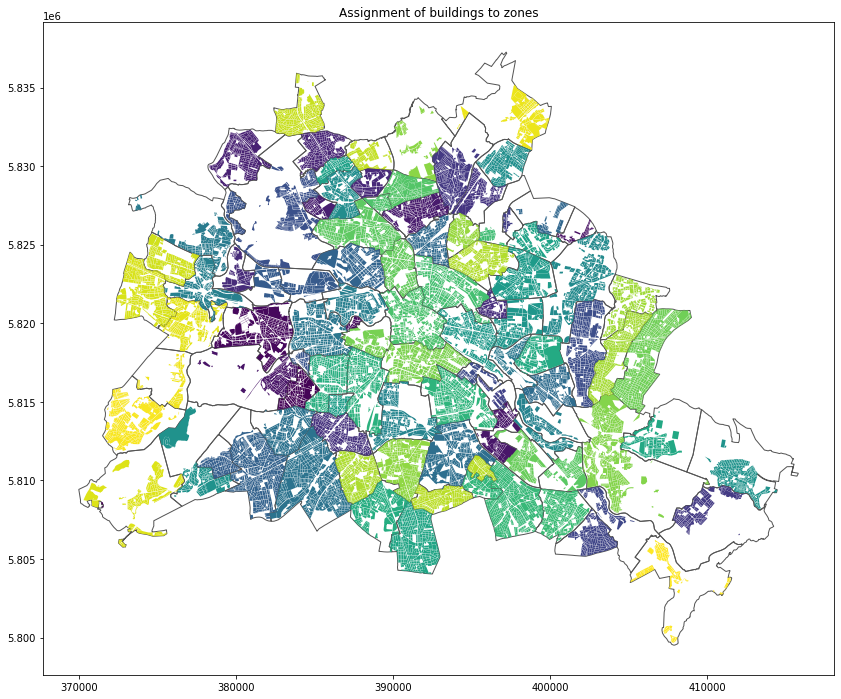

In [29]:
# plot
fig, ax = plt.subplots(figsize = (16,12))
zones.plot(ax=ax, color="#ffffff00", edgecolor="#555")
buildings.plot(ax=ax, column='zone', cmap = "viridis", legend=False)
ax.set_title("Assignment of buildings to zones")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:14. Minutes remaining: 00:00. 

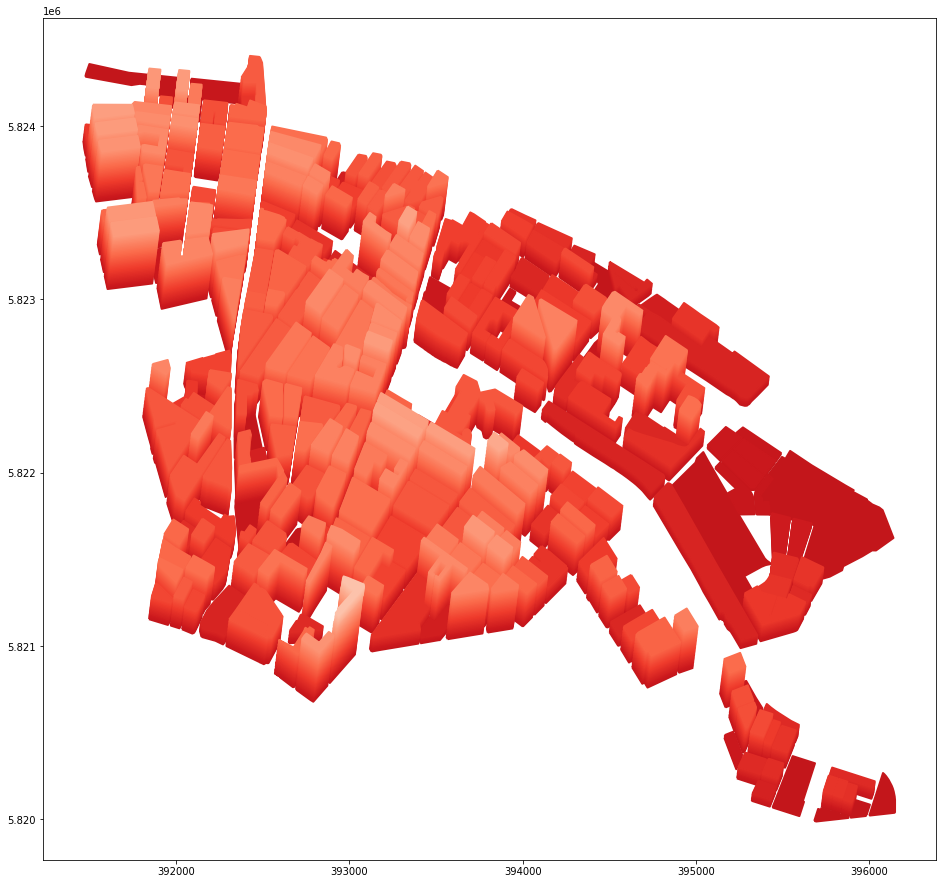

In [30]:
# some map art

from shapely.affinity import translate
import time
sf = ["Prenzlauer Berg"]#["Pankow", "Prenzlauer Berg", "Mitte"]
spb = buildings[buildings["zone"].isin(zones.index[zones["nam"].isin(sf)])]
fig, ax = plt.subplots(figsize = (16,16))
t0 = time.time()

maxHeight = max(spb["ew_ha_2020"])

nSteps = 50
cbuff = 40
cmap = plt.get_cmap('Reds_r', nSteps + cbuff)

for i in range(0,nSteps):
    # spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 1,8) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 1,8) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb.plot(ax=ax, color = cmap(round(i + 0.5*cbuff)), edgecolor = cmap(round(i + 0.5*cbuff)), linewidth = 2)
    # spb.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", linewidth = 2)
    helpers.printProgress(i=i, imax=nSteps, t=time.time(), t0=t0)





### for each zone: sum up population from buildings and create centroids weighted by population

|||||||||||||||||||||||||--------------------------------------------------------------------------- 25%. Minutes elapsed: 00:02. Minutes remaining: 00:05. popCentroid (379953.20541705634, 5827089.732209425) not within polygon for zone 24 Konradshöhe
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:08. Minutes remaining: 00:00. 

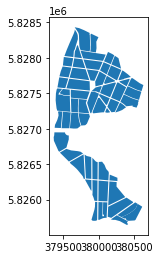

In [31]:
t0=time.time()
# sum up population from buildings to each zone and create centroids weighted by population
zones["pop2020"] = 0
zones["popCentroid"] = Point(0,0)
zones["popCentroidOffset"] = LineString([Point(0,0), Point(0,0)])
zones["popCentroidLat"] = 0
zones["popCentroidLon"] = 0

for zoneIndex, zone in zones.iterrows():
    buildingsInZone = buildings[buildings["zone"]==zoneIndex]
    
    # obtain total zone population and save to zones
    zonePopulation2020 = sum(buildingsInZone["ew2020"])
    zones.at[zoneIndex, "pop2020"] = zonePopulation2020
    
    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for buildingIndex, building in buildingsInZone.iterrows():
        weigthedCoords["lon"] += building["ew2020"] / zonePopulation2020 * building["geometry"].centroid.x
        weigthedCoords["lat"] += building["ew2020"] / zonePopulation2020 * building["geometry"].centroid.y
    
    zones.at[zoneIndex, "popCentroidLat"] = weigthedCoords["lat"]
    zones.at[zoneIndex, "popCentroidLon"] = weigthedCoords["lon"]
    popCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    
    # check whether those centroids which are not within zone are still plausible
    if(not popCentroid.intersects(zone["geometry"])):
        print("popCentroid", popCentroid.coords[0], "not within polygon", "for zone", zoneIndex, zone["nam"])
        buildingsInZone.plot()
    
    zones.loc[zoneIndex, "popCentroid"] = popCentroid
    # add a line between actual centroid and pop centroid
    zones.loc[zoneIndex, "popCentroidOffset"] = LineString([zone["geometry"].centroid, popCentroid])
    helpers.printProgress(i=zoneIndex, imax=len(zones), t=time.time(), t0=t0)

Text(0.5, 1.0, 'Zones centroids vs population weigthed centroids')

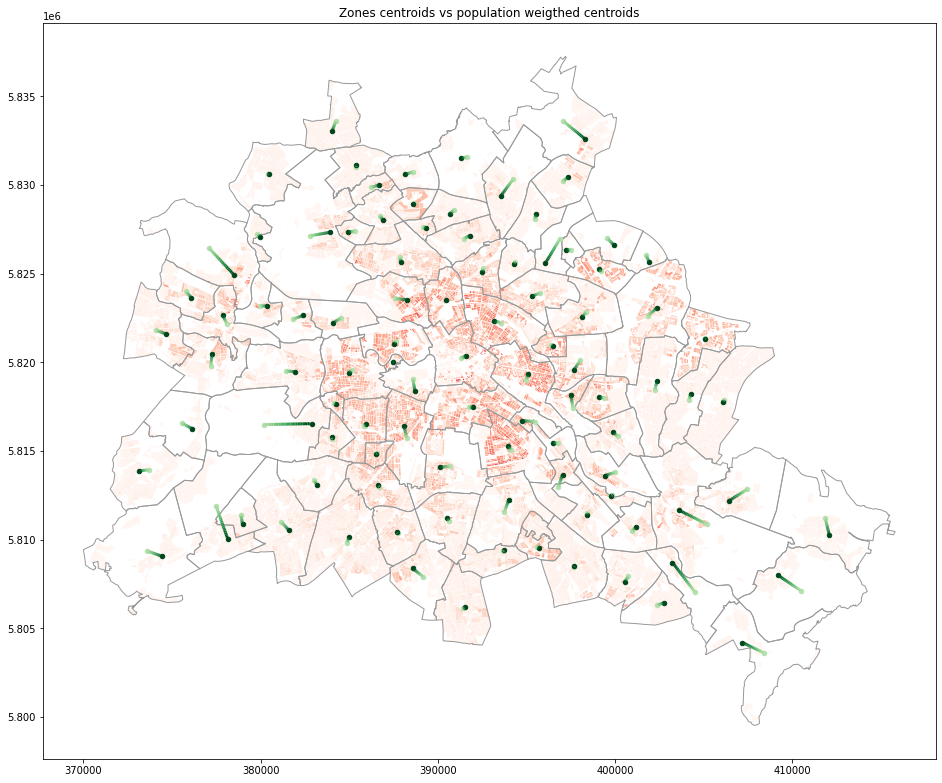

In [32]:
# show zones and popCentroids and their offsets from real geometrical centroids
fig, ax = plt.subplots(1, 1, figsize=(16,16))
buildings.plot(ax=ax, column='ew_ha_2020', cmap = "Reds")
# add zone borders and a bit of opacity
zones.geometry.plot(ax=ax, color = "#ffffff33", edgecolor="#999999")
nSteps = 20
cbuff = 10
cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
gpd.GeoSeries(zones.geometry.centroid).plot(ax=ax, color = cmap(nSteps), markersize = 20)
for i in range(1,nSteps):
    l = list(map(lambda x: helpers.segmentLine(x, i, nSteps), zones.popCentroidOffset))
    gpd.GeoSeries(l).plot(ax=ax,color=cmap(i), linewidth=3)
gpd.GeoSeries(zones.popCentroid).plot(ax=ax, color = cmap(0), markersize = 20)
ax.set_title("Zones centroids vs population weigthed centroids")

<AxesSubplot:>

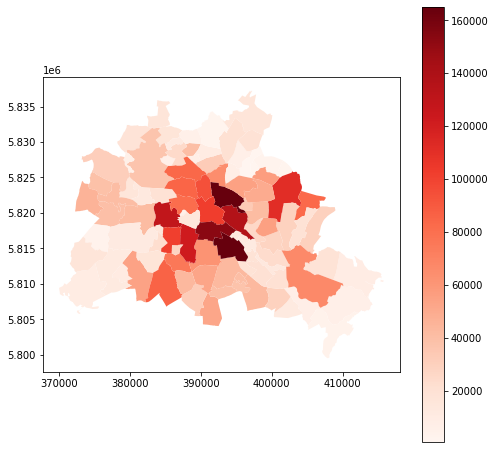

In [33]:
# plot population by zone
zones.plot(column='pop2020', cmap = "Reds", legend=True, figsize = (8,8))

<AxesSubplot:>

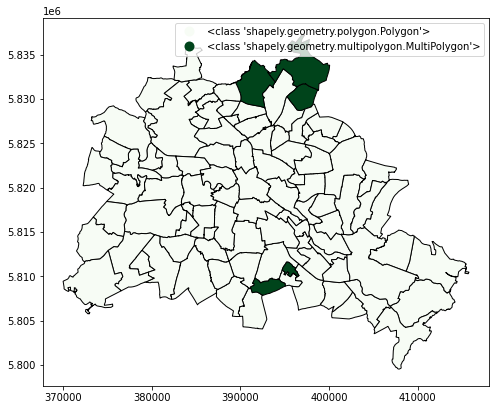

In [38]:
# plot zones by geometry type
zones.plot(column = np.array(list(map(lambda x: type(x), sm.zones["geometry"]))),  cmap = "Greens",  edgecolor="black", legend=True, figsize = (8,8))

### Next steps. Create attractor estimation.

Create attractor fields. <br>
Use school locations. (shapefile already there) <br>
Use Business locations (look up via OSM) <br>
Use Shopping locations (look up via OSM) <br>
Maybe use other data source like traffic data? <br>
Maybe use building height? <br>
Get Data on Mode Choice / Car Ownership for each zone? <br>

## Save model

In [39]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
geomCols = sm.zones.columns[list(sm.zones.dtypes == "geometry")]
# drop all geom columns except the main one named "geometry"
sm.zones = sm.zones.drop(columns = geomCols[geomCols != "geometry"])

In [40]:
# Saving model zones as geojson
sm.to_json(model_path + 'ber_zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]
